## The purpose of this notebook is to evaluate the discriminative capabilities of the representations learned by a post-hoc encoder trained with a fixed generator by performing keyword detection on the SC09 dataset

* We train a Logistic Regression as well as a Random Forest classifier on top of those features and report our performance on the SC09 test set.

### Import packages

In [1]:
import os
os.chdir(os.path.join("/", "home", "c-matsty", "Bi-TiFGAN---TensorFlow-1.14", "src"))

import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix, classification_report, accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score

from feature_evaluation.utils import load_data_labels

### Define paths

In [2]:
data_dir = os.path.join("/media", "datastore", "c-matsty-data", "datasets", "SpeechCommands")

#### Discriminator features path

In [3]:
encoder_features_dirname = "Posthoc_encoder_features"
training_input_path = os.path.join(data_dir, encoder_features_dirname, "training.npy")
test_input_path = os.path.join(data_dir, encoder_features_dirname, "test.npy")

#### Label paths

In [4]:
training_label_dir = os.path.join(data_dir, "SpeechCommands_Preproc_2_training", "labels")
test_label_dir = os.path.join(data_dir, "SpeechCommands_Preproc_2_test", "labels")

### Load data

In [5]:
X_tr = np.load(training_input_path)

In [6]:
X_ts = np.load(test_input_path)

In [7]:
y_tr = load_data_labels(training_label_dir)
y_ts = load_data_labels(test_label_dir)

100%|██████████| 20/20 [00:00<00:00, 3445.58it/s]


In [8]:
label_dict = {value: index  for index, value in enumerate(np.unique(y_tr))}

### Encoded dataset's covariance matrix and mean value

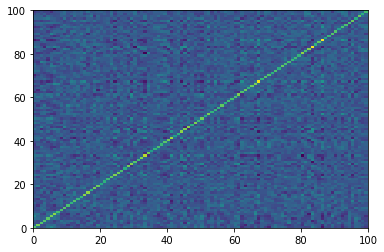

Variance
[0.3341057  0.35734165 0.33735967 0.3374458  0.34202448 0.35740155
 0.3709032  0.3247145  0.33104193 0.33921817 0.33015075 0.30856135
 0.33894315 0.31616712 0.31181866 0.3708708  0.37310848 0.30112857
 0.35315502 0.35093486 0.29492015 0.30236202 0.31959143 0.34324425
 0.36464873 0.35529742 0.3302536  0.29712656 0.35742828 0.3697199
 0.3369337  0.3225361  0.36476222 0.39340433 0.3554645  0.2717022
 0.30912578 0.33081156 0.31765428 0.33996275 0.3594429  0.37926632
 0.2684533  0.30283803 0.37066516 0.36134642 0.37031764 0.3012401
 0.3620213  0.31576207 0.35681295 0.29421312 0.361826   0.30792466
 0.31196898 0.31402537 0.34727436 0.3010723  0.32519743 0.32642734
 0.33166134 0.3629213  0.33403346 0.3522661  0.31282827 0.3526402
 0.35944533 0.41691247 0.3079655  0.33640778 0.3358859  0.30176926
 0.3309569  0.3048615  0.3498948  0.33056474 0.32716557 0.314446
 0.32145813 0.31117576 0.37373167 0.33371967 0.36668873 0.42363653
 0.3066137  0.3467828  0.4261177  0.2844907  0.31467614 0.3

In [9]:
cov = np.cov(X_tr, rowvar=False)
plt.pcolormesh(cov)
plt.show()
print("Variance")
print(X_tr.std(axis=0))

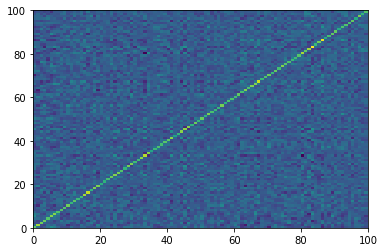

Variance
[0.35213012 0.39158547 0.36331463 0.3599511  0.34376657 0.37531668
 0.3751402  0.34114814 0.34543568 0.3440409  0.36324826 0.31745264
 0.3510167  0.32473573 0.3263277  0.39322892 0.40843007 0.31259874
 0.3690749  0.37078044 0.3069363  0.309579   0.33214405 0.35926116
 0.37388253 0.3679816  0.34355116 0.31437132 0.36729667 0.37262312
 0.32730055 0.32741675 0.3791534  0.40120968 0.37620598 0.2864795
 0.3233958  0.33976093 0.333491   0.34611738 0.3508196  0.37688604
 0.2792728  0.31734768 0.3773662  0.3805759  0.37537423 0.31133837
 0.3603895  0.3170474  0.35835692 0.3121028  0.3721679  0.33527452
 0.3214763  0.3202199  0.3668587  0.30874217 0.33678612 0.33883318
 0.33344918 0.35382167 0.33421138 0.3750539  0.34130055 0.37163776
 0.3717146  0.41117063 0.32084802 0.33981857 0.36191484 0.32095695
 0.35579205 0.3331167  0.37572813 0.349287   0.3408994  0.3253783
 0.32773975 0.34628642 0.39520454 0.35262784 0.38886654 0.43731222
 0.32131496 0.36413187 0.43027195 0.2974826  0.33358172

In [10]:
cov = np.cov(X_ts, rowvar=False)
plt.pcolormesh(cov)
plt.show()
print("Variance")
print(X_ts.std(axis=0))

### Prepare data for training

#### Turn labels from strings to integer identifiers

In [11]:
y_tr = np.vectorize(label_dict.get)(y_tr)
y_ts = np.vectorize(label_dict.get)(y_ts)

#### Reshape input arrays and labels

In [12]:
y_tr = y_tr.flatten()
y_ts = y_ts.flatten()

### Normalize data

In [13]:
mean = X_tr.mean()
std = X_tr.std()
X_tr = (X_tr - mean) / std 
X_ts = (X_ts - mean) / std

### Define sample weights

In [14]:
class_counts = [len(y_tr[y_tr == i]) for i in label_dict.values()]
class_weights = [max(class_counts)/class_count for class_count in class_counts]
class_weight_dict = {class_idx: class_weight for class_idx, class_weight in zip(label_dict.values(), class_weights)}

In [15]:
label_dict

{'eight': 0,
 'five': 1,
 'four': 2,
 'nine': 3,
 'one': 4,
 'seven': 5,
 'six': 6,
 'three': 7,
 'two': 8,
 'zero': 9}

### Train and test logistic regression classifier

In [16]:
multi_class = 'multinomial'
model = LogisticRegression(multi_class=multi_class, max_iter=15000, random_state=0, penalty='elasticnet', solver='saga', l1_ratio=0.5)

In [17]:
sample_weight = [class_weight_dict[label] for label in y_tr]

In [18]:
model = model.fit(X_tr, y_tr, sample_weight=sample_weight)

In [19]:
y_preds = model.predict(X_ts)
print(classification_report(y_ts, y_preds))
print(balanced_accuracy_score(y_ts, y_preds))

              precision    recall  f1-score   support

           0       0.33      0.43      0.37       257
           1       0.37      0.36      0.36       270
           2       0.30      0.32      0.31       253
           3       0.36      0.37      0.37       259
           4       0.31      0.25      0.28       248
           5       0.37      0.41      0.39       239
           6       0.61      0.65      0.63       244
           7       0.28      0.25      0.26       267
           8       0.31      0.23      0.27       264
           9       0.38      0.39      0.39       250

    accuracy                           0.36      2551
   macro avg       0.36      0.37      0.36      2551
weighted avg       0.36      0.36      0.36      2551

0.3660344828262331


### Train and test RandomForest classifier

In [20]:
model = RandomForestClassifier(n_estimators=400, random_state=0)

In [21]:
model = model.fit(X_tr, y_tr, sample_weight=sample_weight)

In [22]:
y_preds = model.predict(X_ts)
print(classification_report(y_ts, y_preds))
print(balanced_accuracy_score(y_ts, y_preds))

              precision    recall  f1-score   support

           0       0.32      0.39      0.35       257
           1       0.30      0.24      0.27       270
           2       0.30      0.33      0.32       253
           3       0.38      0.36      0.37       259
           4       0.28      0.31      0.29       248
           5       0.31      0.32      0.31       239
           6       0.48      0.77      0.60       244
           7       0.24      0.16      0.19       267
           8       0.32      0.23      0.27       264
           9       0.32      0.29      0.31       250

    accuracy                           0.34      2551
   macro avg       0.33      0.34      0.33      2551
weighted avg       0.33      0.34      0.33      2551

0.34078845477920183


### Perform the same as above but test on a held out validation set instead of the test set

In [23]:
multi_class = 'multinomial'
model = LogisticRegression(multi_class=multi_class, max_iter=15000, random_state=0, penalty='elasticnet', solver='saga', l1_ratio=0.5)

In [24]:
sample_weight = [class_weight_dict[label] for label in y_tr]

In [25]:
X_tr, X_ts, y_tr, y_ts = train_test_split(X_tr, y_tr, test_size=0.1, random_state=0)

In [26]:
sample_weight = [class_weight_dict[label] for label in y_tr]

In [27]:
model = model.fit(X_tr, y_tr, sample_weight=sample_weight)

In [28]:
y_preds = model.predict(X_ts)
print(classification_report(y_ts, y_preds))
print(balanced_accuracy_score(y_ts, y_preds))

              precision    recall  f1-score   support

           0       0.34      0.37      0.36       192
           1       0.37      0.41      0.39       193
           2       0.33      0.30      0.31       208
           3       0.36      0.38      0.37       220
           4       0.33      0.33      0.33       212
           5       0.38      0.39      0.39       218
           6       0.57      0.63      0.60       203
           7       0.39      0.28      0.32       224
           8       0.25      0.22      0.24       203
           9       0.40      0.42      0.41       232

    accuracy                           0.37      2105
   macro avg       0.37      0.37      0.37      2105
weighted avg       0.37      0.37      0.37      2105

0.374981956526922


### Train and test RandomForest classifier

In [29]:
model = RandomForestClassifier(n_estimators=400, random_state=0)

In [30]:
model = model.fit(X_tr, y_tr, sample_weight=sample_weight)

In [31]:
y_preds = model.predict(X_ts)
print(classification_report(y_ts, y_preds))
print(balanced_accuracy_score(y_ts, y_preds))

              precision    recall  f1-score   support

           0       0.33      0.31      0.32       192
           1       0.27      0.23      0.25       193
           2       0.33      0.40      0.36       208
           3       0.36      0.41      0.39       220
           4       0.27      0.33      0.30       212
           5       0.34      0.34      0.34       218
           6       0.50      0.75      0.60       203
           7       0.32      0.16      0.21       224
           8       0.31      0.26      0.28       203
           9       0.42      0.34      0.38       232

    accuracy                           0.35      2105
   macro avg       0.35      0.35      0.34      2105
weighted avg       0.35      0.35      0.34      2105

0.35427735649491643
